# Infilling Using Masked Language Model


In this notebook, we use masked language models for time series imputation for Beijing multi-site air quality data.

In [1]:
# System & OS

import sys
import os
import time
import json
import warnings
import random
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
from tqdm import tqdm

# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader

# Script imports

# from data.Vectronics.filter_dataframes import (filter_data)

from src.constants import VECTRONICS_METADATA_PATH

from src.transformer_utils import (collate_fn, 
                                MLMBERT,
                                )

from src.plot_utils import (plot_imputed_acc_data,
                            plot_missing_acc_data)

from src.os_utils import (get_data_path,
                          get_results_path,
                          get_data_path)

from src.data_utils import create_dataset

# Plotting
import matplotlib.pyplot as plt

device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams["axes.labelsize"] = 15
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif' 
plt.rcParams['font.serif'] = ['Times New Roman']

In [3]:
class Arguments:
    def __init__(self,
                    ratio=0.1,
                    batch_size=512,
                    mask_prob=0.1, 
                    mask_avg_len=2):
        self.ratio = ratio
        self.batch_size = batch_size
        self.mask_prob = mask_prob
        self.mask_avg_len = mask_avg_len

with open(os.path.join(get_results_path(), 'model_config.json'), 'r') as f:
    config = json.load(f)
  

In [4]:
args = Arguments()
DEVICE = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

Create train, validation, and test data loaders.

In [5]:
def collate_fn_collapsed(batch):
    return collate_fn(batch, config, args.mask_prob, args.mask_avg_len)

In [6]:
train_dataset, val_dataset, test_dataset = create_dataset(config)
                                                 
# dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn_collapsed)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn_collapsed)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn_collapsed)

/home/medhaaga/bert-multivariate-imputation/src/data_utils.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(get_data_path(), 'data.pth'))

Plot a test observation with missing data.

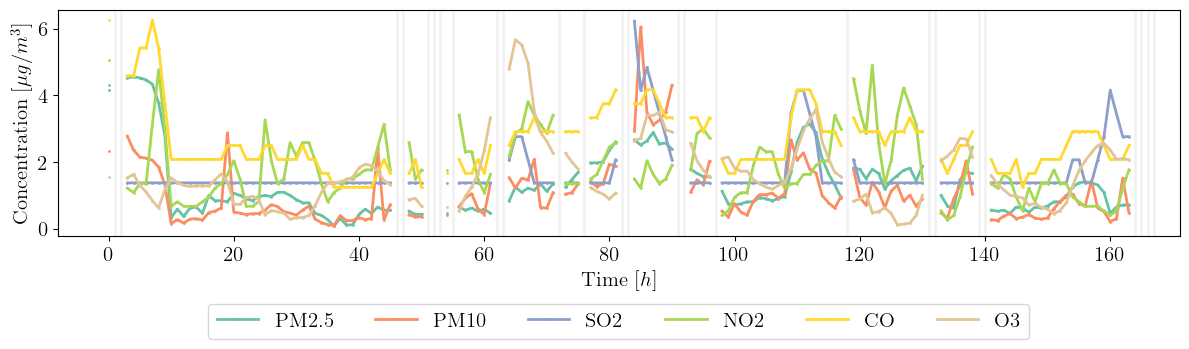

In [7]:
test, mask, static = next(iter(test_dataloader))
test, mask, static = test[0], mask[0], static[0]
plot_missing_acc_data(test, mask)

/tmp/ipykernel_2393450/206384587.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(get_results_path(), 'model.pth')))


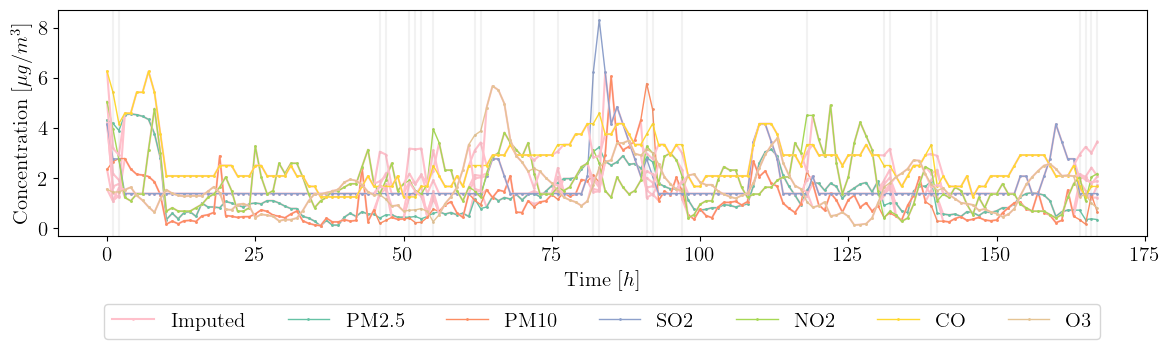

<Figure size 640x480 with 0 Axes>

In [8]:
# plot test obs with imputed data
model = MLMBERT(config).to(device)
model.load_state_dict(torch.load(os.path.join(get_results_path(), 'model.pth')))
all_pred = plot_imputed_acc_data(test, mask, static, model, device, config['mask_token_id'])


In [9]:
# MSE loss for the imputed test observation

masked_test = test.clone()
masked_test[mask] = config['mask_token_id']

with torch.no_grad():
    pred = model(masked_test.unsqueeze(0).to(device))['mask_predictions'].squeeze(0).detach().cpu()

print(torch.mean(torch.square(pred - test[mask])))


tensor(1.5303)


In [10]:
# evolution of training losses

train_losses = torch.load(os.path.join(get_results_path(), 'train_losses.pt'))
valid_losses = torch.load(os.path.join(get_results_path(), 'valid_losses.pt'))
test_losses = torch.load(os.path.join(get_results_path(), 'test_losses.pt'))


/tmp/ipykernel_2393450/3231528536.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_losses = torch.load(os.path.join(get_results_path(), 'train_losses.pt'))
/tmp/ipy

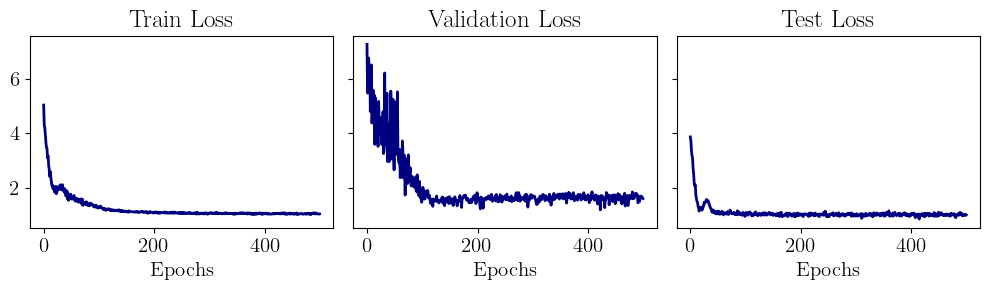

In [11]:
fig, axs = plt.subplots(1, 3, figsize = (10, 3), sharey=True)

axs[0].plot(train_losses, color='navy', linewidth=2)
axs[0].set_xlabel('Epochs')
axs[0].set_title('Train Loss')

axs[1].plot(valid_losses, color='navy', linewidth=2)
axs[1].set_xlabel('Epochs')
axs[1].set_title('Validation Loss')

axs[2].plot(test_losses, color='navy', linewidth=2)
axs[2].set_xlabel('Epochs')
axs[2].set_title('Test Loss')

plt.tight_layout()
plt.show()